In [236]:
import mlrose
import numpy as np
import matplotlib.pyplot as plt
import random
import itertools

In [2]:
# Define alternative N-Queens fitness function for maximization problem
def queens_max(state):
    
    # Initialize counter
    fitness = 0
    
    # For all pairs of queens
    for i in range(len(state) - 1):
        for j in range(i + 1, len(state)):
            
            # Check for horizontal, diagonal-up and diagonal-down attacks
            if (state[j] != state[i]) \
                and (state[j] != state[i] + (j - i)) \
                and (state[j] != state[i] - (j - i)):
                
                # If no attacks, then increment counter
                fitness += 1

    return fitness

In [3]:
# Check function is working correctly
state = np.array([1, 4, 1, 3, 5, 5, 2, 7])

# The fitness of this state should be 22
queens_max(state)

22

In [125]:
# Initialize custom fitness function object
fitness_cust = mlrose.CustomFitness(queens_max)

# Define optimization problem object
problem_cust = mlrose.DiscreteOpt(length = 8, fitness_fn = fitness_cust, maximize = True, max_val = 8)

In [126]:
# Solve using simulated annealing - attempt 1
np.random.seed(1)
init_state = np.array([0, 1, 2, 3, 4, 5, 6, 7])

best_state, best_fitness = mlrose.simulated_annealing(problem_cust, schedule = mlrose.ExpDecay(), 
                                                      max_attempts = 10, max_iters = 1000, 
                                                      init_state = init_state)
print(best_state)
print(best_fitness)

[6 4 7 3 6 2 5 1]
26.0


In [193]:
def random_hill_climb(problem, max_attempts=10, max_iters=np.inf, restarts=0,
                      init_state=None, curve=False, random_state=None):

    if (not isinstance(max_attempts, int) and not max_attempts.is_integer()) \
       or (max_attempts < 0):
        raise Exception("""max_attempts must be a positive integer.""")

    if (not isinstance(max_iters, int) and max_iters != np.inf
            and not max_iters.is_integer()) or (max_iters < 0):
        raise Exception("""max_iters must be a positive integer.""")

    if (not isinstance(restarts, int) and not restarts.is_integer()) \
       or (restarts < 0):
        raise Exception("""restarts must be a positive integer.""")

    if init_state is not None and len(init_state) != problem.get_length():
        raise Exception("""init_state must have same length as problem.""")

    best_fitness = -1*np.inf
    best_state = None

    best_iteration_data = []
    
    for _ in range(restarts + 1):
        # Initialize optimization problem and attempts counter
        if init_state is None:
            problem.reset()
        else:
            problem.set_state(init_state)

        attempts = 0
        iters = 0

        iteration_data = []
        while (attempts < max_attempts) and (iters < max_iters):
            iters += 1

            # Find random neighbor and evaluate fitness
            next_state = problem.random_neighbor()
            next_fitness = problem.eval_fitness(next_state)

            # If best neighbor is an improvement,
            # move to that state and reset attempts counter
            if next_fitness > problem.get_fitness():
                problem.set_state(next_state)
                attempts = 0

            else:
                attempts += 1
            
            iteration_data.append((iters, problem.get_fitness()))
            
        # Update best state and best fitness
        if problem.get_fitness() > best_fitness:
            best_fitness = problem.get_fitness()
            best_state = problem.get_state()
            
            best_iteration_data = iteration_data

    best_fitness = problem.get_maximize()*best_fitness
    return best_state, best_fitness, best_iteration_data

In [194]:
def simulated_annealing(problem, schedule=mlrose.GeomDecay(), max_attempts=10,
                        max_iters=np.inf, init_state=None):

    if (not isinstance(max_attempts, int) and not max_attempts.is_integer()) \
       or (max_attempts < 0):
        raise Exception("""max_attempts must be a positive integer.""")

    if (not isinstance(max_iters, int) and max_iters != np.inf
            and not max_iters.is_integer()) or (max_iters < 0):
        raise Exception("""max_iters must be a positive integer.""")

    if init_state is not None and len(init_state) != problem.get_length():
        raise Exception("""init_state must have same length as problem.""")

    # Initialize problem, time and attempts counter
    if init_state is None:
        problem.reset()
    else:
        problem.set_state(init_state)

    attempts = 0
    iters = 0
    
    iteration_data = []
    while (attempts < max_attempts) and (iters < max_iters):
        temp = schedule.evaluate(iters)
        iters += 1

        if temp == 0:
            break

        else:
            # Find random neighbor and evaluate fitness
            next_state = problem.random_neighbor()
            next_fitness = problem.eval_fitness(next_state)

            # Calculate delta E and change prob
            delta_e = next_fitness - problem.get_fitness()
            prob = np.exp(delta_e/temp)

            # If best neighbor is an improvement or random value is less
            # than prob, move to that state and reset attempts counter
            if (delta_e > 0) or (np.random.uniform() < prob):
                problem.set_state(next_state)
                attempts = 0

            else:
                attempts += 1
        iteration_data.append((iters, problem.get_fitness()))
        
    best_fitness = problem.get_maximize()*problem.get_fitness()
    best_state = problem.get_state()

    return best_state, best_fitness, iteration_data

In [195]:
def genetic_alg(problem, pop_size=200, mutation_prob=0.1, max_attempts=10,
                max_iters=np.inf):

    if pop_size < 0:
        raise Exception("""pop_size must be a positive integer.""")
    elif not isinstance(pop_size, int):
        if pop_size.is_integer():
            pop_size = int(pop_size)
        else:
            raise Exception("""pop_size must be a positive integer.""")

    if (mutation_prob < 0) or (mutation_prob > 1):
        raise Exception("""mutation_prob must be between 0 and 1.""")

    if (not isinstance(max_attempts, int) and not max_attempts.is_integer()) \
       or (max_attempts < 0):
        raise Exception("""max_attempts must be a positive integer.""")

    if (not isinstance(max_iters, int) and max_iters != np.inf
            and not max_iters.is_integer()) or (max_iters < 0):
        raise Exception("""max_iters must be a positive integer.""")

    # Initialize problem, population and attempts counter
    problem.reset()
    problem.random_pop(pop_size)
    attempts = 0
    iters = 0

    iteration_data = []
    while (attempts < max_attempts) and (iters < max_iters):
        iters += 1

        # Calculate breeding probabilities
        problem.eval_mate_probs()

        # Create next generation of population
        next_gen = []

        for _ in range(pop_size):
            # Select parents
            selected = np.random.choice(pop_size, size=2,
                                        p=problem.get_mate_probs())
            parent_1 = problem.get_population()[selected[0]]
            parent_2 = problem.get_population()[selected[1]]

            # Create offspring
            child = problem.reproduce(parent_1, parent_2, mutation_prob)
            next_gen.append(child)

        next_gen = np.array(next_gen)
        problem.set_population(next_gen)

        next_state = problem.best_child()
        next_fitness = problem.eval_fitness(next_state)

        # If best child is an improvement,
        # move to that state and reset attempts counter
        if next_fitness > problem.get_fitness():
            problem.set_state(next_state)
            attempts = 0

        else:
            attempts += 1
            
        iteration_data.append((iters, problem.get_fitness()))

    best_fitness = problem.get_maximize()*problem.get_fitness()
    best_state = problem.get_state()

    return best_state, best_fitness, iteration_data

In [196]:
def mimic(problem, pop_size=200, keep_pct=0.2, max_attempts=10,
          max_iters=np.inf):

    if problem.get_prob_type() == 'continuous':
        raise Exception("""problem type must be discrete or tsp.""")

    if pop_size < 0:
        raise Exception("""pop_size must be a positive integer.""")
    elif not isinstance(pop_size, int):
        if pop_size.is_integer():
            pop_size = int(pop_size)
        else:
            raise Exception("""pop_size must be a positive integer.""")

    if (keep_pct < 0) or (keep_pct > 1):
        raise Exception("""keep_pct must be between 0 and 1.""")

    if (not isinstance(max_attempts, int) and not max_attempts.is_integer()) \
       or (max_attempts < 0):
        raise Exception("""max_attempts must be a positive integer.""")

    if (not isinstance(max_iters, int) and max_iters != np.inf
            and not max_iters.is_integer()) or (max_iters < 0):
        raise Exception("""max_iters must be a positive integer.""")

    # Initialize problem, population and attempts counter
    problem.reset()
    problem.random_pop(pop_size)
    attempts = 0
    iters = 0

    iteration_data = []
    while (attempts < max_attempts) and (iters < max_iters):
        iters += 1

        # Get top n percent of population
        problem.find_top_pct(keep_pct)

        # Update probability estimates
        problem.eval_node_probs()

        # Generate new sample
        new_sample = problem.sample_pop(pop_size)
        problem.set_population(new_sample)

        next_state = problem.best_child()

        next_fitness = problem.eval_fitness(next_state)

        # If best child is an improvement,
        # move to that state and reset attempts counter
        if next_fitness > problem.get_fitness():
            problem.set_state(next_state)
            attempts = 0

        else:
            attempts += 1
            
        iteration_data.append((iters, problem.get_fitness()))

    best_fitness = problem.get_maximize()*problem.get_fitness()
    best_state = problem.get_state().astype(int)

    return best_state, best_fitness, iteration_data

In [239]:
def optimize_rhc(problem):
    parameters = {
                    'restarts': [5, 10, 25, 50]
                 }
    best_score = 0
    best_params = None

    keys, values = zip(*parameters.items())
    for v in itertools.product(*values):
        e = dict(zip(keys, v))
        best_state_rhc, best_fitness_rhc, fitness_curve_rhc = random_hill_climb(problem, max_attempts=100,
                                                                max_iters=250,
                                                               restarts=e['restarts'])
        
        if best_fitness_rhc > best_score:
            best_score = best_fitness_rhc
            best_params = e
            
    return best_score, best_params

def optimize_sa(problem):
    parameters = {
                    'schedule': [mlrose.GeomDecay(), mlrose.ArithDecay(), mlrose.ExpDecay()]
                 }
    best_score = 0
    best_params = None

    keys, values = zip(*parameters.items())
    for v in itertools.product(*values):
        e = dict(zip(keys, v))
        best_state_sa, best_fitness_sa, fitness_curve_sa = simulated_annealing(problem, max_attempts=10,
                                                                max_iters=250,
                                                               schedule = e['schedule'])
        
        if best_fitness_sa > best_score:
            best_score = best_fitness_sa
            best_params = e

    return best_score, best_params

def optimize_ga(problem):
    parameters = {
                    'pop_size': [25, 50, 100, 150, 250],
                    'mutation_prob': [0.01, 0.1, 0.25]
                 }
    best_score = 0
    best_params = None

    keys, values = zip(*parameters.items())
    for v in itertools.product(*values):
        e = dict(zip(keys, v))
        best_state_ga, best_fitness_ga, fitness_curve_ga = genetic_alg(problem, max_attempts=10,
                                                                max_iters=250,
                                                               pop_size=e['pop_size'], mutation_prob=e['mutation_prob'])
        
        if best_fitness_ga > best_score:
            best_score = best_fitness_ga
            best_params = e

    return best_score, best_params

def optimize_mimic(problem):
    parameters = {
                    'pop_size': [25, 50, 100, 150, 250],
                    'keep_pct': [0.01, 0.1, 0.25, 0.5]
                 }
    best_score = 0
    best_params = None

    keys, values = zip(*parameters.items())
    for v in itertools.product(*values):
        e = dict(zip(keys, v))
        best_state_mi, best_fitness_mi, fitness_curve_mi = mimic(nqueens, max_attempts=10,
                                                                max_iters=250,
                                                                pop_size=e['pop_size'],
                                                                keep_pct=e['keep_pct'])
        
        if best_fitness_mi > best_score:
            best_score = best_fitness_mi
            best_params = e

    return best_score, best_params


In [240]:
# Nqueens
fitness_cust = mlrose.CustomFitness(queens_max)
nqueens = mlrose.DiscreteOpt(length = 120, fitness_fn = fitness_cust, maximize = True, max_val = 2)

print('N-Queens')
print('RHC: ', optimize_rhc(nqueens))
print('SA: ', optimize_sa(nqueens))
print('GA: ', optimize_ga(nqueens))
print('MIMIC: ', optimize_mimic(nqueens))

N-Queens
RHC:  (3582.0, {'restarts': 50})
SA:  (3565.0, {'schedule': <mlrose.decay.ExpDecay object at 0x12b2e2588>})
GA:  (3557.0, {'pop_size': 100, 'mutation_prob': 0.25})
MIMIC:  (3580.0, {'pop_size': 250, 'keep_pct': 0.25})


In [244]:
# Flip flop
fitness = mlrose.FlipFlop()
flip_flop = mlrose.DiscreteOpt(200, fitness_fn = fitness, maximize = True, max_val = 2)

print('N-Queens')
print('RHC: ', optimize_rhc(flip_flop))
print('SA: ', optimize_sa(flip_flop))
print('GA: ', optimize_ga(flip_flop))
print('MIMIC: ', optimize_mimic(flip_flop))

N-Queens
RHC:  (166.0, {'restarts': 50})
SA:  (158.0, {'schedule': <mlrose.decay.GeomDecay object at 0x12a649eb8>})
GA:  (131.0, {'pop_size': 250, 'mutation_prob': 0.01})


KeyboardInterrupt: 

In [245]:
# Knapsack
weights = [random.randint(1, 60) for i in range(50)]
values = [random.randint(1, 60) for i in range(50)]
max_weight_pct = 0.6
fitness = mlrose.Knapsack(weights, values, max_weight_pct)
knapsack = mlrose.DiscreteOpt(50, fitness_fn = fitness, maximize = True, max_val = 2)
knapsack_ga = mlrose.DiscreteOpt(50, fitness_fn=fitness, maximize=True, max_val=3)

print('Knapsack')
print('RHC: ', optimize_rhc(knapsack))
print('SA: ', optimize_sa(knapsack))
print('GA: ', optimize_ga(knapsack))
print('MIMIC: ', optimize_mimic(knapsack))

Knapsack
RHC:  (1129.0, {'restarts': 50})
SA:  (1005.0, {'schedule': <mlrose.decay.ArithDecay object at 0x1290ee390>})


/anaconda3/envs/cs4641/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp


GA:  (1178.0, {'pop_size': 100, 'mutation_prob': 0.01})


KeyboardInterrupt: 

In [287]:
def graph_nqueens_fitness_iterations():
    fitness_cust = mlrose.CustomFitness(queens_max)
    nqueens = mlrose.DiscreteOpt(length = 120, fitness_fn = fitness_cust, maximize = True, max_val = 2)

    best_state_rhc, best_fitness_rhc, fitness_curve_rhc = random_hill_climb(nqueens, max_attempts=10,
                                                                max_iters=250,
                                                               restarts=10, curve=True)

    best_state_sa, best_fitness_sa, fitness_curve_sa = simulated_annealing(nqueens, schedule = mlrose.ExpDecay(), 
                                                  max_attempts = 10, max_iters = 250)

    best_state_ga, best_fitness_ga, fitness_curve_ga = genetic_alg(nqueens, max_attempts=10,
                                                                max_iters=250,
                                                               pop_size=100, mutation_prob=0.25)

    best_state_mi, best_fitness_mi, fitness_curve_mi = mimic(nqueens, max_attempts=10,
                                                                max_iters=250,
                                                               pop_size=250, keep_pct=0.25)


    # Plot results
    plt.clf()
    plt.figure()
    plt.title('Fitness over Iterations')
    plt.plot([f[0] for f in fitness_curve_rhc], [f[1] for f in fitness_curve_rhc])
    plt.xlabel('Iterations')
    plt.ylabel('Fitness')
    plt.show()
    plt.close()
    
    plt.figure()
    plt.title('Fitness over Iterations')
    plt.plot([f[0] for f in fitness_curve_sa], [f[1] for f in fitness_curve_sa])
    plt.xlabel('Iterations')
    plt.ylabel('Fitness')
    plt.show()
    plt.close()
    
    plt.figure()
    plt.title('Fitness over Iterations')
    plt.plot([f[0] for f in fitness_curve_ga], [f[1] for f in fitness_curve_ga])
    plt.xlabel('Iterations')
    plt.ylabel('Fitness')
    plt.show()
    plt.close()
    
    plt.figure()
    plt.title('Fitness over Iterations')
    plt.plot([f[0] for f in fitness_curve_mi], [f[1] for f in fitness_curve_mi])
    plt.xlabel('Iterations')
    plt.ylabel('Fitness')
    plt.show()
    plt.close()

<Figure size 432x288 with 0 Axes>

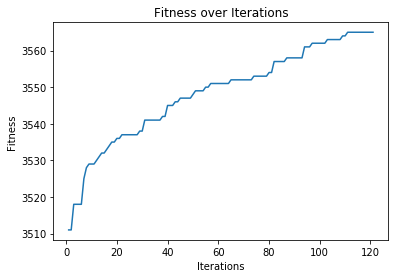

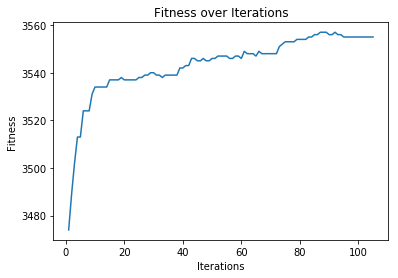

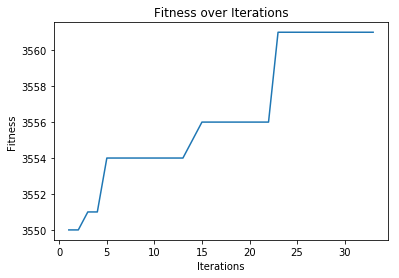

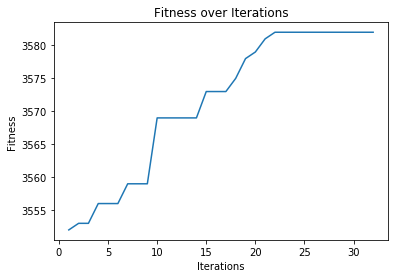

In [288]:
graph_nqueens_fitness_iterations()

In [295]:
def graph_flipflop_fitness_iterations():
    fitness = mlrose.FlipFlop()
    flip_flop = mlrose.DiscreteOpt(200, fitness_fn = fitness, maximize = True, max_val = 3)

    best_state_rhc, best_fitness_rhc, fitness_curve_rhc = random_hill_climb(flip_flop, max_attempts=10,
                                                                max_iters=250,
                                                               restarts=10, curve=True)

    best_state_sa, best_fitness_sa, fitness_curve_sa = simulated_annealing(flip_flop, schedule = mlrose.GeomDecay(), 
                                                  max_attempts = 10, max_iters = 250)

    best_state_ga, best_fitness_ga, fitness_curve_ga = genetic_alg(flip_flop, max_attempts=10,
                                                                max_iters=250,
                                                               pop_size=100, mutation_prob=0.01)

    best_state_mi, best_fitness_mi, fitness_curve_mi = mimic(flip_flop, max_attempts=10,
                                                                max_iters=250,
                                                               pop_size=150, keep_pct=0.1)


    # Plot results
    plt.clf()
    plt.figure()
    plt.title('Fitness over Iterations')
    plt.plot([f[0] for f in fitness_curve_rhc], [f[1] for f in fitness_curve_rhc])
    plt.xlabel('Iterations')
    plt.ylabel('Fitness')
    plt.show()
    plt.close()
    
    plt.figure()
    plt.title('Fitness over Iterations')
    plt.plot([f[0] for f in fitness_curve_sa], [f[1] for f in fitness_curve_sa])
    plt.xlabel('Iterations')
    plt.ylabel('Fitness')
    plt.show()
    plt.close()
    
    plt.figure()
    plt.title('Fitness over Iterations')
    plt.plot([f[0] for f in fitness_curve_ga], [f[1] for f in fitness_curve_ga])
    plt.xlabel('Iterations')
    plt.ylabel('Fitness')
    plt.show()
    plt.close()
    
    plt.figure()
    plt.title('Fitness over Iterations')
    plt.plot([f[0] for f in fitness_curve_mi], [f[1] for f in fitness_curve_mi])
    plt.xlabel('Iterations')
    plt.ylabel('Fitness')
    plt.show()
    plt.close()

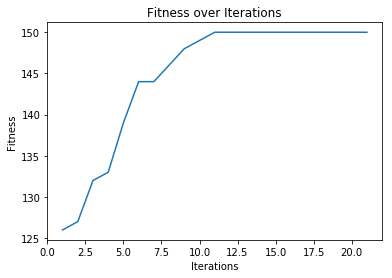

In [296]:
graph_flipflop_fitness_iterations()

In [276]:
def graph_knapsack_fitness_iterations():
    weights = [random.randint(1, 60) for i in range(50)]
    values = [random.randint(1, 60) for i in range(50)]
    max_weight_pct = 0.6
    fitness = mlrose.Knapsack(weights, values, max_weight_pct)
    knapsack = mlrose.DiscreteOpt(50, fitness_fn = fitness, maximize = True, max_val = 2)

    best_state_rhc, best_fitness_rhc, fitness_curve_rhc = random_hill_climb(knapsack, max_attempts=10,
                                                                max_iters=250,
                                                               restarts=10, curve=True)

    best_state_sa, best_fitness_sa, fitness_curve_sa = simulated_annealing(knapsack, schedule = mlrose.ArithDecay(), 
                                                  max_attempts = 10, max_iters = 250)

    best_state_ga, best_fitness_ga, fitness_curve_ga = genetic_alg(knapsack, max_attempts=10,
                                                                max_iters=250,
                                                               pop_size=100, mutation_prob=0.01)

    best_state_mi, best_fitness_mi, fitness_curve_mi = mimic(knapsack, max_attempts=10,
                                                                max_iters=250,
                                                               pop_size=50, keep_pct=0.1)


    # Plot results
    plt.clf()
    plt.figure()
    plt.title('Fitness over Iterations')
    plt.plot([f[0] for f in fitness_curve_rhc], [f[1] for f in fitness_curve_rhc])
    plt.xlabel('Iterations')
    plt.ylabel('Fitness')
    plt.show()
    plt.close()
    
    plt.figure()
    plt.title('Fitness over Iterations')
    plt.plot([f[0] for f in fitness_curve_sa], [f[1] for f in fitness_curve_sa])
    plt.xlabel('Iterations')
    plt.ylabel('Fitness')
    plt.show()
    plt.close()
    
    plt.figure()
    plt.title('Fitness over Iterations')
    plt.plot([f[0] for f in fitness_curve_ga], [f[1] for f in fitness_curve_ga])
    plt.xlabel('Iterations')
    plt.ylabel('Fitness')
    plt.show()
    plt.close()
    
    plt.figure()
    plt.title('Fitness over Iterations')
    plt.plot([f[0] for f in fitness_curve_mi], [f[1] for f in fitness_curve_mi])
    plt.xlabel('Iterations')
    plt.ylabel('Fitness')
    plt.show()
    plt.close()

<Figure size 432x288 with 0 Axes>

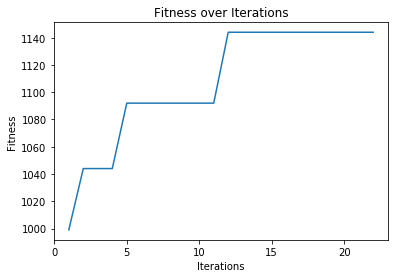

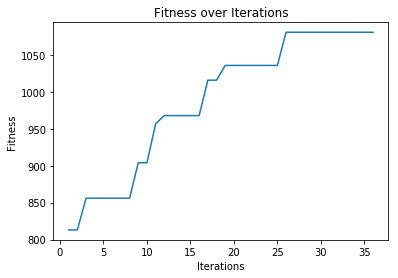

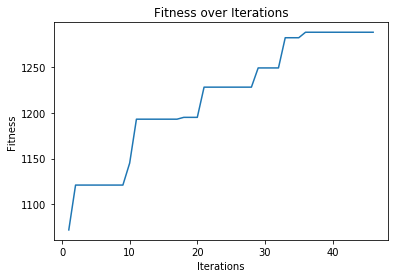

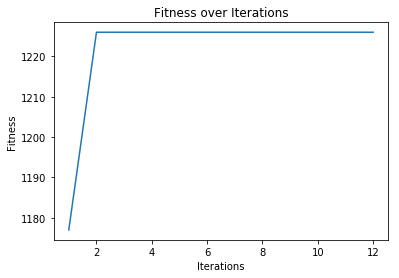

In [277]:
graph_knapsack_fitness_iterations()